# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 0. Loading Test Image

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_name = "straight_lines1.jpg"
test_image = cv2.imread("../media/test_images/"+image_name)
test_imshape = test_image.shape

## 1. Undistorting

### 1.1. Getting Camera Matrix and Distortion Coefficient

Text(0.5, 1.0, 'Undistorted Image')

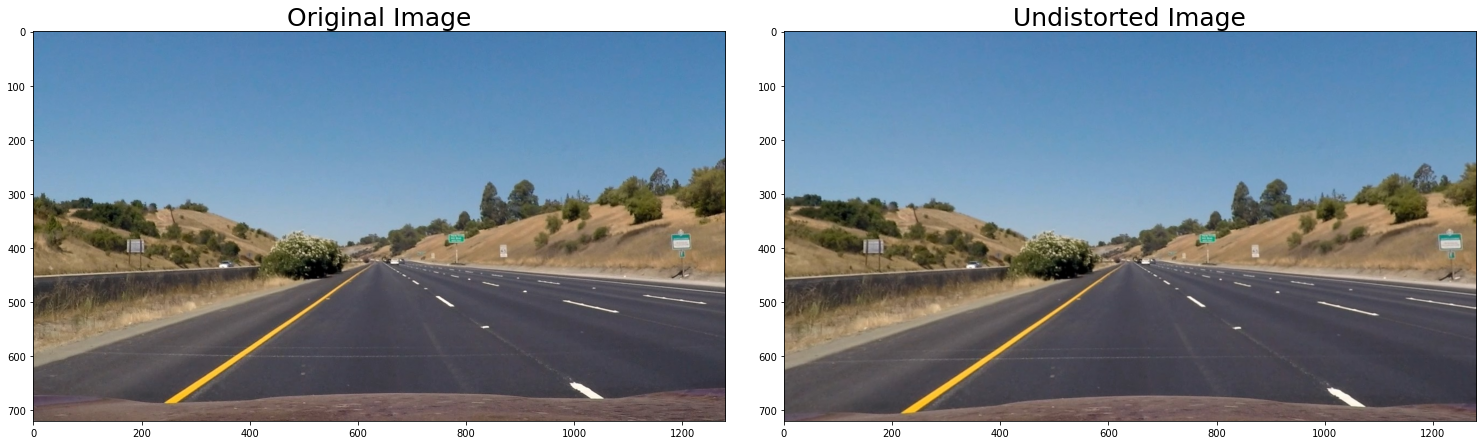

In [6]:
from utils.calibrator import Calibrator
%matplotlib inline

calibrator = Calibrator('../media/camera_cal/calibration*.jpg')
undist_image = calibrator.undistort(test_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
fig.tight_layout()
ax1.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(cv2.cvtColor(undist_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=25)

## 2. Color & Gradients

### 2-1. Gradient Threshold Function

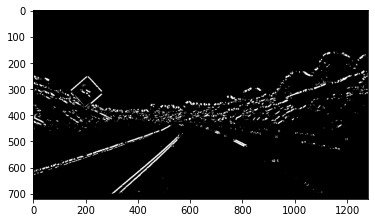

In [47]:
from utils.gradient_threshold import GradientThreshold
%matplotlib inline

grad_thresh = GradientThreshold(sobel_kernel=15, mag_thresh=(50, 255), dir_thresh=(0.7, 1.3))
grad_binary = grad_thresh.grad_select(undist_image)

plt.imshow(grad_binary, cmap='gray')

### 2-2. Color Transform

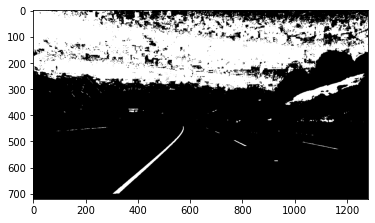

In [48]:
from utils.color_threshold import ColorThreshold
%matplotlib inline

color_thresh = ColorThreshold(white_s_thresh=(0, 255), white_b_thresh=(208, 255), yellow_s_thresh=(100, 255), yellow_b_thresh=(130, 255))
white_lane_binary = color_thresh.hls_select_white(undist_image)
yellow_lane_binary = color_thresh.hls_select_yellow(undist_image)
hls_binary = color_thresh.stack(white_lane_binary, yellow_lane_binary)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
fig.tight_layout()
ax1.imshow(yellow_lane_binary, cmap="gray")
ax1.set_title('Yellow Lane', fontsize=25)
ax2.imshow(white_lane_binary, cmap="gray")
ax2.set_title('White Lane', fontsize=25)
ax3.imshow(hls_binary, cmap="gray")
ax3.set_title('Combined', fontsize=25)

### 2-3. Combining Color and Gradient

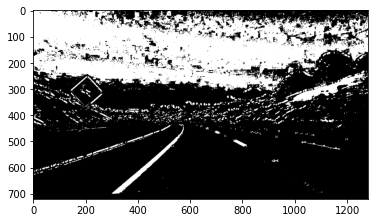

In [49]:
%matplotlib inline

color_binary = color_thresh.stack(grad_binary, hls_binary)

plt.imshow(color_binary, cmap="gray")

## 3. Perspective Transform

### 3-1. Warp Function

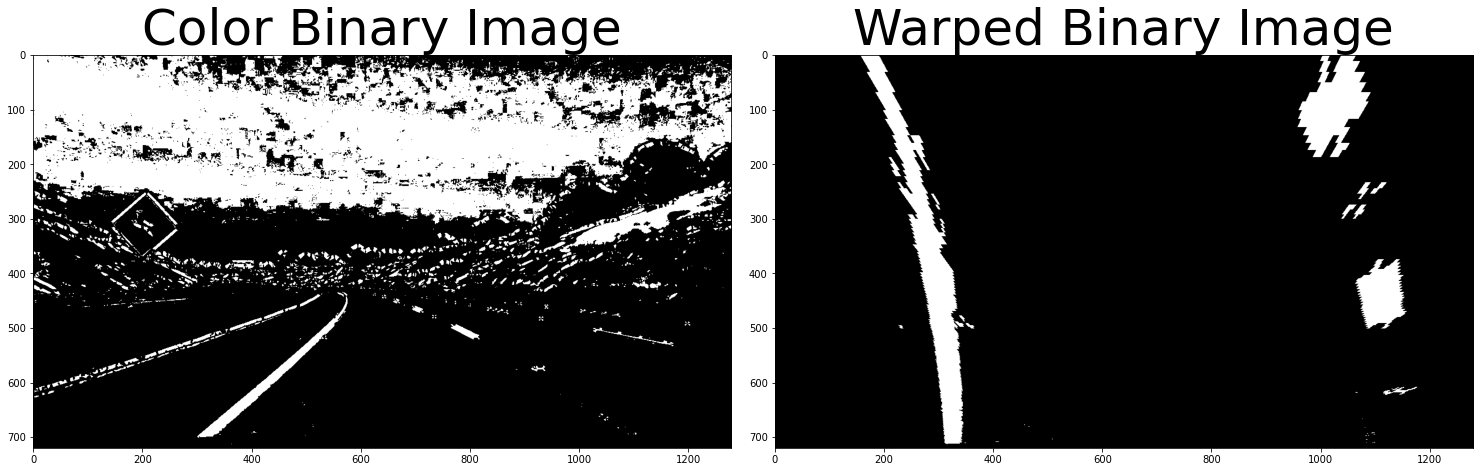

In [50]:
from utils.perspective_transformer import PerspectiveTransformer
%matplotlib inline

warper = PerspectiveTransformer(test_imshape, [[575,460],[705,460],[1130,720],[150,720]], 200)
warped_binary = warper.warp_image(color_binary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.tight_layout()
ax1.imshow(color_binary, cmap='gray')
ax1.set_title('Color Binary Image', fontsize=50)
ax2.imshow(warped_binary, cmap='gray')
ax2.set_title('Warped Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## 4. Lane Finding

### 4-1. Sliding Window & Curve fitting

598.9408371682421 419.8552719169863
0.7429723484968601


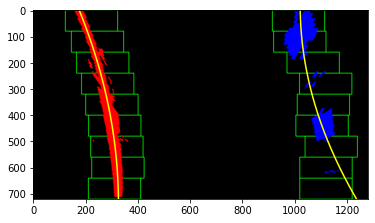

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.lane_line_finder import LaneLineFinder
%matplotlib inline


# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


frame_lane_line = LaneLineFinder(warped_binary, ym_per_pix, xm_per_pix)

sliwin_image = frame_lane_line.get_sliwin_image()
frame_lane_line.plot_lane_graph(plt)

left_curverad, right_curverad = frame_lane_line.get_curvature_real()
cte = frame_lane_line.get_cte_real()

print(left_curverad, right_curverad)
print(cte)
plt.imshow(sliwin_image)

### 4-2. Visualizing on Undistorted Image

In [52]:
%matplotlib qt

warped_lane_image = frame_lane_line.get_lane_image()
unwarped_lane_image = warper.unwarp_image(warped_lane_image)

result = cv2.addWeighted(undist_image, 1, unwarped_lane_image, 0.5, 0)
if cte>=0:
    txt = f"Vehicle is {cte:.2f}m right of center"
else:
    txt = f"Vehicle is {-cte:.2f}m left of center"
cv2.putText(result, f"Radius of Curvature = {left_curverad:4.0f}(m) left", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
cv2.putText(result, f"Radius of Curvature = {right_curverad:4.0f}(m) right", (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

cv2.putText(result, txt, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

cv2.imshow("result", result)

## 5. Video Output

### 5-1. Video Pipeline

In [53]:
%matplotlib qt

def process_image(image):
    # 1. undistort
    undist_image = calibrator.undistort(image)
    # 2. apply gradient threshold
    grad_binary = grad_thresh.grad_select(undist_image)
    # 3. apply color threshold
    white_lane_binary = color_thresh.hls_select_white(undist_image)
    yellow_lane_binary = color_thresh.hls_select_yellow(undist_image)
    hls_binary = color_thresh.stack(white_lane_binary, yellow_lane_binary)
    # 4. combine
    color_binary = color_thresh.stack(grad_binary, hls_binary)
    # 5. warp to birdeye view
    warped_binary = warper.warp_image(color_binary)
    # 6. find lane
    frame_lane_line = LaneLineFinder(warped_binary, ym_per_pix, xm_per_pix)
    # 7. draw lane line
    warped_lane_image = frame_lane_line.get_lane_image()
    unwarped_lane_image = warper.unwarp_image(warped_lane_image)
    # 8. get curvature radius and cte
    left_curverad, right_curverad = frame_lane_line.get_curvature_real()
    \
    cte = frame_lane_line.get_cte_real()

    # 9. write data on frame
    result = cv2.addWeighted(undist_image, 1, unwarped_lane_image, 0.5, 0)
    if cte>=0:
        txt = f"Vehicle is {cte:.2f}m right of center"
    else:
        txt = f"Vehicle is {-cte:.2f}m left of center"
    cv2.putText(result, f"Radius of Curvature = {left_curverad:4.0f}(m) left", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    cv2.putText(result, f"Radius of Curvature = {right_curverad:4.0f}(m) right", (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    
    cv2.putText(result, txt, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    return result



In [55]:
for i in range(0,6):
    image_name = "straight_lines"+str(i+1)+".jpg"
    test_image = cv2.imread("../media/test_images/"+image_name)
    
    result = process_image(test_image)

    cv2.imwrite("../media/output_images/"+image_name, result)

### 5-2. Compile Video

In [56]:
from moviepy.editor import VideoFileClip

video_name = 'project_video.mp4'

clip1 = VideoFileClip("../media/test_video/"+video_name)
video_output = '../media/output_video/'+video_name

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

Moviepy - Building video ../media/output_video/project_video.mp4.
Moviepy - Writing video ../media/output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready ../media/output_video/project_video.mp4
Wall time: 4min 1s
